The intent of this algorithm is to model the incredibly complex interplay of patient's race and gender, the diagnosis given by the health care professionals, and the amount of time required to successfully provide care to the patient and bring them back to good health. Since many health insurance providers struggle to strike the right balance between providing the purported service for their clients and trying to make as much profit as possible from wherever possible, this algorithm models those factors and provides a simple, succinct, and mathmatically rigorous recommendation to ease this tremendous burden from the claims adjusters.

The scenario modeled here are situations where the health insurance provider (in this case the federal government acting through Medicare) has covered the full cost of the patient’s bill from the hospital. Situations where less than the full amount are covered represent anomalies or deviations from what the expected behavior from the heath care provider and, as with other erroneous data, these events are not included in the training data. 

As mentioned above, the features of the model reflect the patient's race and gender, the diagnosis given by the health care professionals, and the amount of time required to successfully provide care. The target variable...

#### Training data:
- ["CMS 2008-2010 Data Entrepreneurs’ Synthetic Public Use File (DE-SynPUF)" dataset](https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/DE_Syn_PUF.html)

In [1]:
import glob
import json
import os
import re
import zipfile
import numpy as np
import pandas as pd
import requests

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display

from sklearn_transformers.preprocessing import FeatureSelector
from sklearn_transformers.preprocessing import MultiColumnLabelEncoder
from sklearn_transformers.classification import BinaryClassifierWithNoise
import classifier_report

In [2]:
def handle_zip(filename, label):
    with zipfile.ZipFile(filename, 'r') as f:
        f.extractall(f'{label}')
    for fn in glob.glob(f'{label}/*.csv'):
        _filename, _ext = os.path.splitext(os.path.basename(s))
        new_local = f'{os.path.dirname(fn)}__raw_data{_ext}'
        os.replace(fn, new_local)
    os.rmdir(f'{label}/')
    os.remove(filename)
    return new_local

### Download data:

The primary source of data for this model comes from Centers for Medicaid & Medicare Services through a series of datasets named the Data Entrepreneurs’ Synthetic Public Use File or DE-SynPUF for short. From the website: 
>The DE-SynPUF was created with the goal of providing a realistic set of claims data in the public domain while providing the very highest degree of protection to the Medicare beneficiaries’ protected health information.

There are two datasets that will be used for this model: the Beneficiary summary data, and the Inpatient Claims data. The Beneficiary summary data contains information about the beneficiary of the claim, and for the purposes of the mode only the gender, race, and birthdate will be used. The Inpatient Claims data describes the nature of the claim itself, and will be limited to only information about the price of the services, the financial liabilities placed upon the patient, the primary diagnosis, and the duration of the stay at the hospital. 

In [35]:
base_url = 'https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/'
year_range = range(2008, 2011)
sample_range = range(1, 21)

for year in year_range:
    for sample_number in sample_range:
        url = f'{base_url}DE1_0_{year}_Beneficiary_Summary_File_Sample_{sample_number}.zip'
        filename = os.path.basename(url)
        label = os.path.splitext(filename)[0]
        response = requests.get(url)
        if response.status_code != 200:
            print(f'ERROR: {response.url}, {response.status_code}')
            continue
        with open(filename, 'wb') as out_file:
            out_file.write(response.content)
        new_filename = handle_zip(filename, label)
        print(f'successfully downloaded [{url}] to [{new_filename}]')

successfully downloaded [https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/DE1_0_2008_Beneficiary_Summary_File_Sample_1.zip] to [DE1_0_2008_Beneficiary_Summary_File_Sample_1__raw_data.csv]
successfully downloaded [https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/DE1_0_2008_Beneficiary_Summary_File_Sample_2.zip] to [DE1_0_2008_Beneficiary_Summary_File_Sample_2__raw_data.csv]
successfully downloaded [https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/DE1_0_2008_Beneficiary_Summary_File_Sample_3.zip] to [DE1_0_2008_Beneficiary_Summary_File_Sample_3__raw_data.csv]
successfully downloaded [https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/DE1_0_2008_Beneficiary_Summary_File_Sample_4.zip] to [DE1_0_2008_Beneficiary_Summary_File_Sample_4__raw_data.csv]
successfully downloaded 

successfully downloaded [https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/DE1_0_2009_Beneficiary_Summary_File_Sample_15.zip] to [DE1_0_2009_Beneficiary_Summary_File_Sample_15__raw_data.csv]
successfully downloaded [https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/DE1_0_2009_Beneficiary_Summary_File_Sample_16.zip] to [DE1_0_2009_Beneficiary_Summary_File_Sample_16__raw_data.csv]
successfully downloaded [https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/DE1_0_2009_Beneficiary_Summary_File_Sample_17.zip] to [DE1_0_2009_Beneficiary_Summary_File_Sample_17__raw_data.csv]
successfully downloaded [https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/DE1_0_2009_Beneficiary_Summary_File_Sample_18.zip] to [DE1_0_2009_Beneficiary_Summary_File_Sample_18__raw_data.csv]
successfully dow

In [39]:
beneficiary_filenames = [filename for filename in glob.glob('*__raw_data.csv') if 'beneficiary' in filename.lower()]
beneficiary_df = pd.concat([pd.read_csv(f) for f in beneficiary_filenames])
beneficiary_df = beneficiary_df.rename(columns={
    'BENE_SEX_IDENT_CD': 'GENDER',
    'BENE_RACE_CD': 'RACE',
    'BENE_BIRTH_DT': 'BIRTHDATE',
})
beneficiary_df = beneficiary_df[[
    'DESYNPUF_ID',
    'GENDER',
    'RACE',
    'BIRTHDATE',
]]

print(beneficiary_df.shape)
beneficiary_df.sample(5)

(6760520, 4)


,DESYNPUF_ID,GENDER,RACE,BIRTHDATE
50112,72374BDA6FE0D65B,1,1,19301001
42726,5FB38B9D42C1E292,1,1,19370401
87615,C707DC8F57D13D5E,2,2,19380101
5520,0C712E7C6C9E316A,2,2,19430501
111648,F995EF4BA3589EDE,1,1,19260901


In [41]:
base_url = 'https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/'
year_range = range(2008, 2011)
sample_range = range(1, 21)

for sample_number in sample_range:
    url = f'{base_url}DE1_0_2008_to_2010_Inpatient_Claims_Sample_{sample_number}.zip'
    filename = os.path.basename(url)
    label = os.path.splitext(filename)[0]
    response = requests.get(url)
    if response.status_code != 200:
        print(f'ERROR: {response.url}, {response.status_code}')
        continue
    with open(filename, 'wb') as out_file:
        out_file.write(response.content)
    new_filename = handle_zip(filename, label)
    print(f'successfully downloaded [{url}] to [{new_filename}]')

successfully downloaded [https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/DE1_0_2008_to_2010_Inpatient_Claims_Sample_1.zip] to [DE1_0_2008_to_2010_Inpatient_Claims_Sample_1__raw_data.csv]
successfully downloaded [https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/DE1_0_2008_to_2010_Inpatient_Claims_Sample_2.zip] to [DE1_0_2008_to_2010_Inpatient_Claims_Sample_2__raw_data.csv]
successfully downloaded [https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/DE1_0_2008_to_2010_Inpatient_Claims_Sample_3.zip] to [DE1_0_2008_to_2010_Inpatient_Claims_Sample_3__raw_data.csv]
successfully downloaded [https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/DE1_0_2008_to_2010_Inpatient_Claims_Sample_4.zip] to [DE1_0_2008_to_2010_Inpatient_Claims_Sample_4__raw_data.csv]
successfully downloaded 

In [397]:
claims_filenames = [filename for filename in glob.glob('*__raw_data.csv') if 'inpatient_claims' in filename.lower()]
claims_df = pd.concat([pd.read_csv(f) for f in claims_filenames])
claims_df = claims_df[[
    'DESYNPUF_ID', 
    'ICD9_DGNS_CD_1',
    'PRVDR_NUM',
    'CLM_UTLZTN_DAY_CNT',
    'CLM_THRU_DT',
    'CLM_PMT_AMT',
    'CLM_PASS_THRU_PER_DIEM_AMT',
    'NCH_PRMRY_PYR_CLM_PD_AMT',
    'NCH_BENE_PTA_COINSRNC_LBLTY_AM',
    'NCH_BENE_IP_DDCTBL_AMT',
    'NCH_BENE_BLOOD_DDCTBL_LBLTY_AM',
]]
claims_df['NCH_PRMRY_PYR_CLM_PD_AMT'] = claims_df['NCH_PRMRY_PYR_CLM_PD_AMT'].fillna(0)
claims_df['NCH_BENE_PTA_COINSRNC_LBLTY_AM'] = claims_df['NCH_BENE_PTA_COINSRNC_LBLTY_AM'].fillna(0)
claims_df['NCH_BENE_IP_DDCTBL_AMT'] = claims_df['NCH_BENE_IP_DDCTBL_AMT'].fillna(0)
claims_df['NCH_BENE_BLOOD_DDCTBL_LBLTY_AM'] = claims_df['NCH_BENE_BLOOD_DDCTBL_LBLTY_AM'].fillna(0)
print(claims_df.shape)
claims_df.sample(5)

(1332822, 11)


,DESYNPUF_ID,ICD9_DGNS_CD_1,PRVDR_NUM,CLM_UTLZTN_DAY_CNT,CLM_THRU_DT,CLM_PMT_AMT,CLM_PASS_THRU_PER_DIEM_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,NCH_BENE_PTA_COINSRNC_LBLTY_AM,NCH_BENE_IP_DDCTBL_AMT,NCH_BENE_BLOOD_DDCTBL_LBLTY_AM
53184,CB01624EF6ED9BBA,V5789,3100UR,7.0,20081009.0,15000.0,0.0,0.0,0.0,1024.0,0.0
10923,2A0475421F0BE5D8,29644,0100MD,0.0,20080205.0,6000.0,80.0,0.0,0.0,1024.0,0.0
18224,4649EF8E95690712,42821,0600NQ,3.0,20091017.0,5000.0,0.0,0.0,0.0,1068.0,0.0
45312,AF23BC1BC3D85328,99642,23006G,1.0,20100814.0,2000.0,0.0,0.0,0.0,1100.0,0.0
34051,81D7E0EEEE9B66B8,V5789,14018H,12.0,20080302.0,12000.0,0.0,0.0,0.0,1024.0,0.0


In [672]:
df = claims_df.merge(beneficiary_df, on='DESYNPUF_ID')
df = df.rename(columns={column: column.strip().lower().replace(' ', '_') for column in df.columns})
df = df.dropna(subset=['icd9_dgns_cd_1'])
df = df.drop_duplicates()
print(df.shape)
df.sample(5)

(1331036, 14)


,desynpuf_id,icd9_dgns_cd_1,prvdr_num,clm_utlztn_day_cnt,clm_thru_dt,clm_pmt_amt,clm_pass_thru_per_diem_amt,nch_prmry_pyr_clm_pd_amt,nch_bene_pta_coinsrnc_lblty_am,nch_bene_ip_ddctbl_amt,nch_bene_blood_ddctbl_lblty_am,gender,race,birthdate
3393539,619F5D56FF8DA432,4580,10S0NQ,6.0,20080802.0,4000.0,0.0,0.0,0.0,1024.0,0.0,2,5,19131201
2255349,AAAA42280B8A44CB,5990,0413KV,5.0,20081016.0,4000.0,100.0,0.0,0.0,1024.0,0.0,2,2,19310201
2008840,23FDCC7C740C1281,5550,0100GU,4.0,20090824.0,14000.0,70.0,0.0,0.0,1068.0,0.0,1,2,19370801
1915690,A1F6D9E7A147FBA3,00845,4500PK,5.0,20080703.0,9000.0,0.0,0.0,0.0,1024.0,0.0,2,1,19701201
3046977,A5E747C95FA8C3D0,V5878,4401CB,36.0,20080427.0,8000.0,0.0,0.0,2000.0,1024.0,0.0,1,1,19280901


### Preprocess:

In order to transform the raw data into a state prepared for modeling, some preprocessing must occur. The preprocesing step for this model is fairly complex and relies heavily on the documentation provided by the Centers for Medicaid & Medicare Services. The numerous fields found within the DE-SynPUF data are described at length in the [Centers for Medicare and Medicaid Services (CMS) Linkable 2008–2010 Medicare Data Entrepreneurs’ Synthetic Public Use File (DE-SynPUF) User Manual](https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/SynPUF_DUG.pdf).

There are five predominant steps for feature engineering:`determine_duration_bin()`, `decode_icd9()`, `provider_state_name`, `age_range`, `determine_coverage()`, as well as the cleanup and standarization of some columns.

The first step, `determine_duration_bin()`, is a simple truncation of the length in days of the patient’s claim duration into categorical ranges loosely based on the volume of entries that fall into these bins, ensuring similarly size bins are used within the model.

In [673]:
def determine_duration_bin(claim_duration):
    if claim_duration == 1:
        return '1 day'
    elif claim_duration == 2:
        return '2 days'
    elif claim_duration == 3:
        return '3 days'
    elif claim_duration == 4:
        return '4 days'
    elif claim_duration == 5:
        return '5 days'
    elif 5 < claim_duration <= 7:
        return '6-7 days'
    elif 7 < claim_duration <= 14:
        return '8-14 days'
    elif 14 < claim_duration:
        return '15 days or more'
    return

df['claim_duration'] = df['clm_utlztn_day_cnt'].apply(determine_duration_bin).astype('category')
df = df.dropna(subset=['claim_duration'])
df.sample(5)

,desynpuf_id,icd9_dgns_cd_1,prvdr_num,clm_utlztn_day_cnt,clm_thru_dt,clm_pmt_amt,clm_pass_thru_per_diem_amt,nch_prmry_pyr_clm_pd_amt,nch_bene_pta_coinsrnc_lblty_am,nch_bene_ip_ddctbl_amt,nch_bene_blood_ddctbl_lblty_am,gender,race,birthdate,claim_duration
3123017,0672667B4EA78977,99673,34S0KQ,1.0,20090213.0,17000.0,30.0,0.0,0.0,1068.0,0.0,1,1,19390401,1 day
1696350,8555D13944DA4AFA,4359,1000AQ,1.0,20080419.0,10000.0,0.0,0.0,0.0,1024.0,0.0,2,1,19570501,1 day
99473,7EEA1AC82F5A6766,42820,5000PS,3.0,20080519.0,7000.0,0.0,0.0,0.0,1024.0,0.0,1,2,19250601,3 days
2976863,4C72C65B5DE19D8F,0389,3901GM,16.0,20100424.0,16000.0,0.0,0.0,0.0,1100.0,0.0,2,1,19231001,15 days or more
2155959,2B1A1D7DBA88C4E0,1830,3400SP,7.0,20080526.0,13000.0,0.0,0.0,0.0,1024.0,0.0,1,2,19490301,6-7 days


The diagnosis claim codes come in the form of an [ICD-9](https://en.wikipedia.org/wiki/International_Statistical_Classification_of_Diseases_and_Related_Health_Problems#ICD-9) code based on the [International Classification of Diseases](https://en.wikipedia.org/wiki/International_Statistical_Classification_of_Diseases_and_Related_Health_Problems) maintained by the [World Health Organization (WHO)](https://en.wikipedia.org/wiki/World_Health_Organization). The code ranges used by the function `decode_icd9()` are based on the categorical groupings outlined [here](https://en.wikipedia.org/wiki/List_of_ICD-9_codes). This step is used to condense the wide range of ICD-9 codes into groups of similar codes which reduces the complexity of this field when modeling while still generally describing the nature of the health care professional’s original diagnosis.

In [674]:
icd9_regex = re.compile(r'^[A-Z]')

def decode_icd9(code):
    if icd9_regex.match(str(code)):
        return 'external causes of injury and supplemental classification'
    code = int(str(code)[:3])
    if 1 <= code <= 139:
        return 'infectious and parasitic diseases'
    elif 140 <= code <= 239: 
        return 'neoplasms'
    elif 240 <= code <= 279: 
        return 'endocrine, nutritional and metabolic diseases, and immunity disorders'
    elif 280 <= code <= 289: 
        return 'diseases of the blood and blood-forming organs'
    elif 290 <= code <= 319: 
        return 'mental disorders'
    elif 320 <= code <= 389: 
        return 'diseases of the nervous system and sense organs'
    elif 390 <= code <= 459: 
        return 'diseases of the circulatory system'
    elif 460 <= code <= 519: 
        return 'diseases of the respiratory system'
    elif 520 <= code <= 579: 
        return 'diseases of the digestive system'
    elif 580 <= code <= 629: 
        return 'diseases of the genitourinary system'
    elif 630 <= code <= 679: 
        return 'complications of pregnancy, childbirth, and the puerperium'
    elif 680 <= code <= 709: 
        return 'diseases of the skin and subcutaneous tissue'
    elif 710 <= code <= 739: 
        return 'diseases of the musculoskeletal system and connective tissue'
    elif 740 <= code <= 759: 
        return 'congenital anomalies'
    elif 760 <= code <= 779: 
        return 'certain conditions originating in the perinatal period'
    elif 780 <= code <= 799: 
        return 'symptoms, signs, and ill-defined conditions'
    elif 800 <= code <= 999: 
        return 'injury and poisoning'
    return

df['diagnosis_class'] = df['icd9_dgns_cd_1'].apply(decode_icd9)
df[['diagnosis_class']].sample(5)

,diagnosis_class
3508697,diseases of the circulatory system
1325762,neoplasms
478351,"symptoms, signs, and ill-defined conditions"
858356,diseases of the circulatory system
2678673,neoplasms


In [675]:
# def determine_percent_paid(row):
#     payment_amount = row['clm_pmt_amt']
#     if payment_amount > 0:
#         amount = (payment_amount - row['nch_bene_pta_coinsrnc_lblty_am'] - row['nch_bene_ip_ddctbl_amt']) / payment_amount
# #         return '100' if amount >= 1 else 'other'
#         return amount
#     return


# # df['nch_bene_ip_ddctbl_amt'] = df['nch_bene_ip_ddctbl_amt'].fillna(0)
# df['percent_paid'] = df.apply(determine_percent_paid, axis=1)
# df = df.dropna(subset=['percent_paid'])

In [676]:
# state_regions = {
#     'northeast': ['CT', 'ME', 'MA', 'NH', 'RI', 'VT', 'NY', 'NJ' , 'PA'],
#     'midwest': ['IL', 'IN', 'MI', 'OH', 'WI', 'IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD'],
#     'south': ['DE', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 'DC', 'WV', 'AL', 'KY', 'MS', 'TN', 'AR', 'LA', 'OK', 'TX', 'PR', 'AS', 'VI'],
#     'west': ['AZ', 'CO', 'ID', 'MT', 'NV', 'NM', 'UT', 'WY', 'AK', 'CA', 'HI', 'OR', 'WA', 'GU', 'FM', 'MH', 'MP', 'PW'],
# }

# def convert_region(state_abbr):
#     for region, states in state_regions.items():
#         if state_abbr in states:
#             return region
#     return

# df['provider_region'] = df['provider_state_abbr'].apply(convert_region)

This step converts the `prvdr_num` representing the medical facility hosting the individual into the name of the state where the facility is located. This improves the predictive power of the model by adding geographical nuance to the situations represented in the data.

In [33]:
states_df = pd.DataFrame([
    {'provider_code': '01', 'provider_state_abbr': 'AL', 'provider_state_name': 'alabama'},
    {'provider_code': '02', 'provider_state_abbr': 'AK', 'provider_state_name': 'alaska'},
    {'provider_code': '03', 'provider_state_abbr': 'AZ', 'provider_state_name': 'arizona'},
    {'provider_code': '04', 'provider_state_abbr': 'AR', 'provider_state_name': 'arkansas'},
    {'provider_code': '05', 'provider_state_abbr': 'CA', 'provider_state_name': 'california'},
    {'provider_code': '06', 'provider_state_abbr': 'CO', 'provider_state_name': 'colorado'},
    {'provider_code': '07', 'provider_state_abbr': 'CT', 'provider_state_name': 'connecticut'},
    {'provider_code': '08', 'provider_state_abbr': 'DE', 'provider_state_name': 'delaware'},
    {'provider_code': '09', 'provider_state_abbr': 'DC', 'provider_state_name': 'washington dc'},
    {'provider_code': '10', 'provider_state_abbr': 'FL', 'provider_state_name': 'florida'},
    {'provider_code': '11', 'provider_state_abbr': 'GA', 'provider_state_name': 'georgia'},
    {'provider_code': '12', 'provider_state_abbr': 'HI', 'provider_state_name': 'hawaii'},
    {'provider_code': '13', 'provider_state_abbr': 'ID', 'provider_state_name': 'idaho'},
    {'provider_code': '14', 'provider_state_abbr': 'IL', 'provider_state_name': 'illinois'},
    {'provider_code': '15', 'provider_state_abbr': 'IN', 'provider_state_name': 'indiana'},
    {'provider_code': '16', 'provider_state_abbr': 'IA', 'provider_state_name': 'iowa'},
    {'provider_code': '17', 'provider_state_abbr': 'KS', 'provider_state_name': 'kansas'},
    {'provider_code': '18', 'provider_state_abbr': 'KY', 'provider_state_name': 'kentucky'},
    {'provider_code': '19', 'provider_state_abbr': 'LA', 'provider_state_name': 'louisiana'},
    {'provider_code': '20', 'provider_state_abbr': 'ME', 'provider_state_name': 'maine'},
    {'provider_code': '21', 'provider_state_abbr': 'MD', 'provider_state_name': 'maryland'},
    {'provider_code': '22', 'provider_state_abbr': 'MA', 'provider_state_name': 'massachusetts'},
    {'provider_code': '23', 'provider_state_abbr': 'MI', 'provider_state_name': 'michigan'},
    {'provider_code': '24', 'provider_state_abbr': 'MN', 'provider_state_name': 'minnesota'},
    {'provider_code': '25', 'provider_state_abbr': 'MS', 'provider_state_name': 'mississippi'},
    {'provider_code': '26', 'provider_state_abbr': 'MO', 'provider_state_name': 'missouri'},
    {'provider_code': '27', 'provider_state_abbr': 'MT', 'provider_state_name': 'montana'},
    {'provider_code': '28', 'provider_state_abbr': 'NE', 'provider_state_name': 'nebraska'},
    {'provider_code': '29', 'provider_state_abbr': 'NV', 'provider_state_name': 'nevada'},
    {'provider_code': '30', 'provider_state_abbr': 'NH', 'provider_state_name': 'new hampshire'},
    {'provider_code': '31', 'provider_state_abbr': 'NJ', 'provider_state_name': 'new jersey'},
    {'provider_code': '32', 'provider_state_abbr': 'NM', 'provider_state_name': 'new mexico'},
    {'provider_code': '33', 'provider_state_abbr': 'NY', 'provider_state_name': 'new york'},
    {'provider_code': '34', 'provider_state_abbr': 'NC', 'provider_state_name': 'north carolina'},
    {'provider_code': '35', 'provider_state_abbr': 'ND', 'provider_state_name': 'north dakota'},
    {'provider_code': '36', 'provider_state_abbr': 'OH', 'provider_state_name': 'ohio'},
    {'provider_code': '37', 'provider_state_abbr': 'OK', 'provider_state_name': 'oklahoma'},
    {'provider_code': '38', 'provider_state_abbr': 'OR', 'provider_state_name': 'oregon'},
    {'provider_code': '39', 'provider_state_abbr': 'PA', 'provider_state_name': 'pennsylvania'},
    {'provider_code': '41', 'provider_state_abbr': 'RI', 'provider_state_name': 'rhode island'},
    {'provider_code': '42', 'provider_state_abbr': 'SC', 'provider_state_name': 'south carolina'},
    {'provider_code': '43', 'provider_state_abbr': 'SD', 'provider_state_name': 'south dakota'},
    {'provider_code': '44', 'provider_state_abbr': 'TN', 'provider_state_name': 'tennessee'},
    {'provider_code': '45', 'provider_state_abbr': 'TX', 'provider_state_name': 'texas'},
    {'provider_code': '46', 'provider_state_abbr': 'UT', 'provider_state_name': 'utah'},
    {'provider_code': '47', 'provider_state_abbr': 'VT', 'provider_state_name': 'vermont'},
    {'provider_code': '49', 'provider_state_abbr': 'VA', 'provider_state_name': 'virginia'},
    {'provider_code': '50', 'provider_state_abbr': 'WA', 'provider_state_name': 'washington'},
    {'provider_code': '51', 'provider_state_abbr': 'WV', 'provider_state_name': 'west virginia'},
    {'provider_code': '52', 'provider_state_abbr': 'WI', 'provider_state_name': 'wisconsin'},
    {'provider_code': '53', 'provider_state_abbr': 'WY', 'provider_state_name': 'wyoming'},
    {'provider_code': '40', 'provider_state_abbr': 'PR', 'provider_state_name': 'puerto rico'},
])

df['provider_code'] = df['prvdr_num'].str[:2]
df = df.merge(states_df, left_on='provider_code', right_on='provider_code')
df = df.rename(columns={'provider_state_name': 'facility_state'})
df[['prvdr_num', 'provider_code', 'facility_state']].sample(5)

,prvdr_num,provider_code,facility_state
16400,0502VR,05,california
4463,4200NV,42,south carolina
17517,1401HG,14,illinois
2274,10S0MP,10,florida
29827,1700JJ,17,kansas


This step is to creates the `age_range` feature by using the beneficiary's birthdate to calculate the age they were when they were hospitalized, then that age is truncated to a decade span.

In [679]:
df['clm_thru_dt'] = pd.to_datetime(df['clm_thru_dt'], format='%Y%m%d')
df['birthdate'] = pd.to_datetime(df['birthdate'], format='%Y%m%d')
df['age'] = df['clm_thru_dt'].dt.year - df['birthdate'].dt.year
df['age_min'] = np.floor(df['age'] / 10) * 10
df['age_max'] = np.ceil((df['age'] + 1) / 10) * 10
df['age_range'] = df['age_min'].astype('int64').map(str) + '-' + df['age_max'].astype('int64').map(str)
df[['birthdate', 'clm_thru_dt', 'age', 'age_min', 'age_max', 'age_range']].sample(5)

,birthdate,clm_thru_dt,age,age_min,age_max,age_range
556764,1936-07-01,2009-04-25,73,70.0,80.0,70-80
646062,1941-10-01,2008-02-20,67,60.0,70.0,60-70
497255,1943-04-01,2009-12-22,66,60.0,70.0,60-70
817599,1938-07-01,2009-10-08,71,70.0,80.0,70-80
495471,1924-10-01,2008-02-15,84,80.0,90.0,80-90


Only observations where the beneficiary paid exactly \\$0.00 for their deductible, and where the insurance provider paid more than \\$0.00 are kept for the final model. These situations represent the expectations of the beneficiary when they the insurance provider: the insurance provider will cover the costs of hospitalization if the person happens to unfortunately require medical attention. Since there are numerous cases where a person had to pay an additional cost beyond what they're already paying to the insurance provider in the form of a deductible, they are excluded from the model.

In [681]:
df = df[(df['nch_bene_ip_ddctbl_amt'] == 0) & (df['clm_pmt_amt'] >= 0)]

The following step is to ultimately calculate the percent amount of coverage the insuance provider paid of the total bill. The first calculation is to determine how much the benficiary paid (`amount_paid_by_beneficiary`) and is a sum of the columns where some financial burden offloaded onto the hospitalized person. The next calculation, `amount_covered_by_insurers`, determines the amount paid by the insurers. These two numbers combined equals the the `total_amount` amount of the claim, and from there the `percent_covered_by_insurers` is derived. Lastly, the `percent_covered_by_insurers` is converted into a binary class representing cases when the insurance provider covered 100\% of the costs, and when they failed to do so.

The fields below are [defined](https://www.resdac.org/cms-data/files/op-ffs/data-documentation) as:
- `nch_bene_pta_coinsrnc_lblty_am` : The amount of money for which the intermediary has determined that the beneficiary is liable for Part A coinsurance on the institutional claim.
- `nch_bene_ip_ddctbl_amt`: The amount of the deductible the beneficiary paid for inpatient services, as originally submitted on the institutional claim.
- `nch_bene_blood_ddctbl_lblty_am`: The amount of money for which the intermediary determined the beneficiary is liable for the blood deductible. A blood deductible amount applies to the first 3 pints of blood (or equivalent units; applies only to whole blood or packed red cells - not platelets, fibrinogen, plasma, etc. which are considered biologicals).
- `clm_pmt_amt`: The Medicare claim payment amount.
- `clm_pass_thru_per_diem_amt`: Medicare establishes a daily payment amount to reimburse IPPS hospitals for certain “pass-through” expenses, such as capital-related costs, direct medical education costs, kidney acquisition costs for hospitals that are renal transplant centers, and bad debts. This variable is the daily payment rate for pass-through expenses. It is not included in the CLM_PMT_AMT field. To determine the total of the pass-through payments for a hospitalization, this field should be multiplied by the claim Medicare utilization day count (CLM_UTLZTN_DAY_CNT). Then, total Medicare payments for a hospitalization claim can be determined by summing this product and the CLM_PMT_AMT field. 
- `clm_utlztn_day_cnt`: On an institutional claim, the number of covered days of care that are chargeable to Medicare facility utilization that includes full days, coinsurance days, and lifetime reserve days.
- `nch_prmry_pyr_clm_pd_amt`: The amount of a payment made on behalf of a Medicare beneficiary by a primary payer other than Medicare, that the provider is applying to covered Medicare charges on a non-institutional claim. 

In [682]:
def determine_coverage(series):
    return np.where(series == 1, '100', '0')

df['amount_paid_by_beneficiary'] = df['nch_bene_pta_coinsrnc_lblty_am'] + df['nch_bene_ip_ddctbl_amt'] + df['nch_bene_blood_ddctbl_lblty_am']
df['amount_covered_by_insurers'] = df['clm_pmt_amt'] + (df['clm_pass_thru_per_diem_amt'] * df['clm_utlztn_day_cnt']) + df['nch_prmry_pyr_clm_pd_amt']
df['total_amount'] = df['amount_covered_by_insurers'] + df['amount_paid_by_beneficiary']
df['percent_covered_by_insurers'] = df['amount_covered_by_insurers'] / df['total_amount']
df = df.dropna(subset=['percent_covered_by_insurers'])
df['coverage'] = determine_coverage(df['percent_covered_by_insurers'])
df.sample(5)

/Users/brianclifton/.local/share/virtualenvs/algorithms-yp66jMGA/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/brianclifton/.local/share/virtualenvs/algorithms-yp66jMGA/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/brianclifton/.local/share/virtualenvs/algorithms-yp66jMGA/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A

,desynpuf_id,icd9_dgns_cd_1,prvdr_num,clm_utlztn_day_cnt,clm_thru_dt,clm_pmt_amt,clm_pass_thru_per_diem_amt,nch_prmry_pyr_clm_pd_amt,nch_bene_pta_coinsrnc_lblty_am,nch_bene_ip_ddctbl_amt,nch_bene_blood_ddctbl_lblty_am,gender,race,birthdate,claim_duration,diagnosis_class,provider_code,provider_state_abbr,facility_state,age,age_min,age_max,age_range,amount_paid_by_beneficiary,amount_covered_by_insurers,total_amount,percent_covered_by_insurers,coverage
16462,CD61CAD136DEBF4A,56983,4900HJ,7.0,2008-06-19,15000.0,0.0,0.0,0.0,0.0,0.0,2,1,1932-10-01,6-7 days,diseases of the digestive system,49,VA,Virginia,76,70.0,80.0,70-80,0.0,15000.0,15000.0,1.0,100
428588,013096B120F9726A,29574,4400QH,1.0,2008-08-25,5000.0,0.0,0.0,0.0,0.0,0.0,2,1,1962-11-01,1 day,mental disorders,44,TN,Tennessee,46,40.0,50.0,40-50,0.0,5000.0,5000.0,1.0,100
802942,59CCB4634A26E59E,4271,3420KJ,1.0,2008-09-18,5000.0,70.0,0.0,0.0,0.0,0.0,2,2,1953-11-01,1 day,diseases of the circulatory system,34,NC,North Carolina,55,50.0,60.0,50-60,0.0,5070.0,5070.0,1.0,100
204137,C7A32774C107F492,V5789,1500QB,13.0,2009-03-19,22000.0,0.0,0.0,0.0,0.0,0.0,2,1,1920-01-01,8-14 days,external causes of injury and supplemental classification,15,IN,Indiana,89,80.0,90.0,80-90,0.0,22000.0,22000.0,1.0,100
775956,6047ACCAB630E8D0,57400,3900NM,4.0,2008-05-19,7000.0,0.0,18000.0,0.0,0.0,0.0,2,1,1920-02-01,4 days,diseases of the digestive system,39,PA,Pennsylvania,88,80.0,90.0,80-90,0.0,25000.0,25000.0,1.0,100


Lastly, a few field replacements are used to transform numeric codes into human-readable categorical values.

In [683]:
field_replacements = {
    'race': {
        1: 'white',
        2: 'black',
        3: 'others',
        5: 'hispanic',
    },
    'gender': {
        1: 'male',
        2: 'female',
    }
}

df['race'] = df['race'].apply(lambda x: field_replacements['race'].get(x)).astype('category')
df['gender'] = df['gender'].apply(lambda x: field_replacements['gender'].get(x)).astype('category')
df[['race', 'gender']].sample(5)

,race,gender
552613,black,male
658957,white,female
128016,black,female
149273,white,male
732123,white,female


In [4]:
# df.to_csv('health_insurance_claim.csv')
# --------------------------------
df = pd.read_csv('health_insurance_claim.csv')
df = df.drop(columns=['Unnamed: 0'])
df.head()

,desynpuf_id,icd9_dgns_cd_1,prvdr_num,clm_utlztn_day_cnt,clm_thru_dt,clm_pmt_amt,clm_pass_thru_per_diem_amt,nch_prmry_pyr_clm_pd_amt,nch_bene_pta_coinsrnc_lblty_am,nch_bene_ip_ddctbl_amt,nch_bene_blood_ddctbl_lblty_am,gender,race,birthdate,claim_duration,diagnosis_class,provider_code,provider_state_abbr,facility_state,age,age_min,age_max,age_range,amount_paid_by_beneficiary,amount_covered_by_insurers,total_amount,percent_covered_by_insurers,coverage
0,007D1D46DA73C8DE,99851,4900NA,3.0,2008-06-25,5000.0,0.0,0.0,0.0,0.0,0.0,male,others,1944-09-01,3 days,injury and poisoning,49,VA,Virginia,64,60.0,70.0,60-70,0.0,5000.0,5000.0,1.0,100
1,0116BD170E3E73BE,41401,4900NA,10.0,2009-07-29,13000.0,0.0,0.0,0.0,0.0,0.0,female,white,1931-11-01,8-14 days,diseases of the circulatory system,49,VA,Virginia,78,70.0,80.0,70-80,0.0,13000.0,13000.0,1.0,100
2,066D268FC641FCDF,25080,49008K,2.0,2009-03-29,4000.0,300.0,0.0,0.0,0.0,0.0,male,white,1943-12-01,2 days,"endocrine, nutritional and metabolic diseases, and immunity disorders",49,VA,Virginia,66,60.0,70.0,60-70,0.0,4600.0,4600.0,1.0,100
3,087C749FD98CD6AB,42833,4920MC,41.0,2008-05-12,15000.0,0.0,0.0,0.0,0.0,0.0,male,white,1943-02-01,15 days or more,diseases of the circulatory system,49,VA,Virginia,65,60.0,70.0,60-70,0.0,15000.0,15000.0,1.0,100
4,0BFC4022602CA31A,41519,4901US,4.0,2009-07-12,6000.0,90.0,0.0,0.0,0.0,0.0,female,white,1938-12-01,4 days,diseases of the circulatory system,49,VA,Virginia,71,70.0,80.0,70-80,0.0,6360.0,6360.0,1.0,100


In [62]:
df['coverage'] = df['coverage'].astype(str)

### Model:

In [564]:
# import numpy as np
# from sklearn.base import BaseEstimator
# from sklearn.base import ClassifierMixin


# class BinaryClassifierWithNoise(BaseEstimator, ClassifierMixin):
#     def __init__(self, classifier):
#         self.classifier = classifier

#     def _add_noise(self, predictions):
#         adj_predictions = predictions - np.random.rand(len(predictions), 1) * 0.001
#         first_value = np.absolute(adj_predictions).take(0, axis=1)
#         second_value = 1 - first_value
#         return np.stack([first_value, second_value], axis=1)

#     def _add_target_labels(self, predictions):
#         return [dict(zip(self.classifier.classes_, prediction)) for prediction in predictions]

#     def fit(self, x, y):
#         return self.classifier.fit(x, y)

#     def predict(self, x):
#         return self.classifier.predict(x)

#     def predict_proba(self, x):
#         predictions = self.classifier.predict_proba(x)
#         predictions = self._add_noise(predictions)
#         return self._add_target_labels(predictions)

In [63]:
df.dtypes

desynpuf_id                        object
icd9_dgns_cd_1                     object
prvdr_num                          object
clm_utlztn_day_cnt                float64
clm_thru_dt                        object
clm_pmt_amt                       float64
clm_pass_thru_per_diem_amt        float64
nch_prmry_pyr_clm_pd_amt          float64
nch_bene_pta_coinsrnc_lblty_am    float64
nch_bene_ip_ddctbl_amt            float64
nch_bene_blood_ddctbl_lblty_am    float64
gender                             object
race                               object
birthdate                          object
claim_duration                     object
diagnosis_class                    object
provider_code                      object
provider_state_abbr_x              object
age                                 int64
age_min                           float64
age_max                           float64
age_range                          object
amount_paid_by_beneficiary        float64
amount_covered_by_insurers        

In [64]:
feature_columns = ['gender','race','age_range','claim_duration','diagnosis_class','facility_state']
target_column = 'coverage'

data_df = pd.concat([df, df, df]) # Boost the number of observations, improving model performance

x = data_df.copy()[feature_columns]
y = data_df.copy()[target_column]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1337)

print(len(x_train), len(x_test))

96813 24204


In [65]:
model = Pipeline([
    ('feature_selector', FeatureSelector(feature_columns)),
    ('feature_column_encoder', MultiColumnLabelEncoder(columns=feature_columns)),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=True)),
    ('classifier', BinaryClassifierWithNoise(
        RandomForestClassifier(
            n_estimators=100,
            n_jobs=1,
            random_state=1337,
        )
    )),
])
model.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('feature_selector',
                 FeatureSelector(columns=['gender', 'race', 'age_range',
                                          'claim_duration', 'diagnosis_class',
                                          'facility_state'])),
                ('feature_column_encoder',
                 <sklearn_transformers.preprocessing.MultiColumnLabelEncoder object at 0x1305fe710>),
                ('encoder',
                 OneHotEncoder(categorical_features=None, categories=None,
                               drop=None, dtype=<cla...
                 BinaryClassifierWithNoise(classifier=RandomForestClassifier(bootstrap=True,
                                                                             class_weight=None,
                                                                             criterion='gini',
                                                                             max_depth=None,
                                             

Accuracy:  0.974550
Recall:    0.446988
F-beta:    0.546392
Precision: 0.702652

----------------------------------------
Feature Importances:
age_range=70-80                                                                       0.051160
age_range=80-90                                                                       0.047678
age_range=60-70                                                                       0.044301
gender=male                                                                           0.036001
gender=female                                                                         0.035525
age_range=90-100                                                                      0.026755
age_range=50-60                                                                       0.025642
claim_duration=15 days or more                                                        0.023657
race=white                                                                            0.021900
fa

None

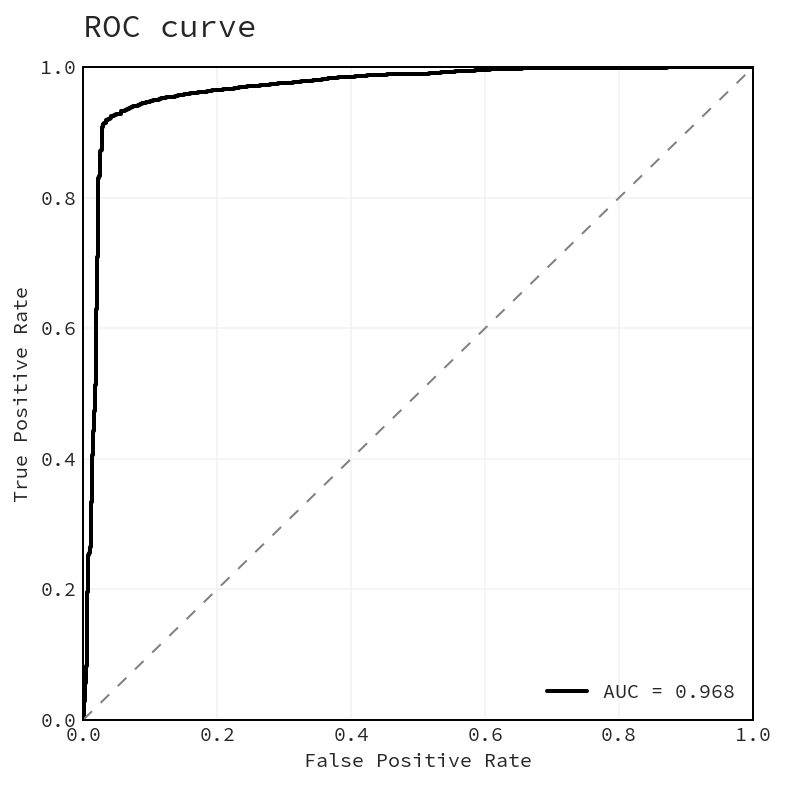

None

[{'0': 0.22405573355061761, '100': 0.7759442664493824},
 {'0': 0.009707201768862899, '100': 0.9902927982311371},
 {'0': 0.019832191584061572, '100': 0.9801678084159384},
 {'0': 0.012417868467474344, '100': 0.9875821315325256},
 {'0': 0.05807611632750874, '100': 0.9419238836724912}]

In [66]:
display(classifier_report.performance(model, x_test, y_test, encoder_step_label='feature_column_encoder', cross_validate=False))
display(classifier_report.roc_curve(model, x_test, y_test))
display(model.predict_proba(x_test.sample(5)))

In [67]:
model['classifier'].classifier.classes_

array(['0', '100'], dtype=object)

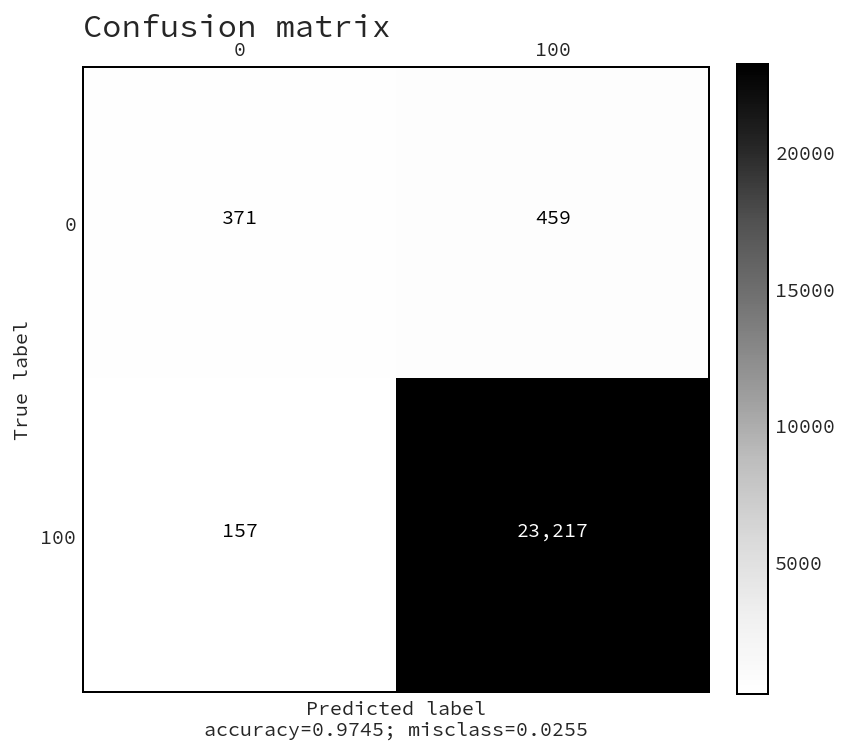

In [68]:
y_pred = model.predict(x_test)
class_names = model['classifier'].classifier.classes_
classifier_report.plot_confusion_matrix(y_test, y_pred, class_names=class_names, normalize=False)

In [12]:
import dill
import boto3

def save_model(model, filename):
    model_filename = f'{filename}.model'
    with open(model_filename, 'wb') as outfile:
        dill.dump(model, outfile)
    print(f'model [{model_filename}] saved.')
    
def upload_model_to_s3(filename):
    model_filename = f'{filename}.model'
    s3 = boto3.resource('s3')
    s3.meta.client.upload_file(
        Filename=model_filename,
        Bucket='fafcsafs-models',
        Key=model_filename
    )
    print(f'model [{model_filename}] uploaded to s3.')


In [69]:
save_model(model, 'health_insurance_claim')
upload_model_to_s3('health_insurance_claim')

model [health_insurance_claim.model] saved.
model [health_insurance_claim.model] uploaded to s3.


In [39]:
for col, enc in model['feature_column_encoder'].encodings.items():
    for c in enc.classes_:
        print(f'{col}={c}')

gender=female
gender=male
race=black
race=hispanic
race=others
race=white
age_range=100-110
age_range=20-30
age_range=30-40
age_range=40-50
age_range=50-60
age_range=60-70
age_range=70-80
age_range=80-90
age_range=90-100
claim_duration=1 day
claim_duration=15 days or more
claim_duration=2 days
claim_duration=3 days
claim_duration=4 days
claim_duration=5 days
claim_duration=6-7 days
claim_duration=8-14 days
diagnosis_class=complications of pregnancy, childbirth, and the puerperium
diagnosis_class=congenital anomalies
diagnosis_class=diseases of the blood and blood-forming organs
diagnosis_class=diseases of the circulatory system
diagnosis_class=diseases of the digestive system
diagnosis_class=diseases of the genitourinary system
diagnosis_class=diseases of the musculoskeletal system and connective tissue
diagnosis_class=diseases of the nervous system and sense organs
diagnosis_class=diseases of the respiratory system
diagnosis_class=diseases of the skin and subcutaneous tissue
diagnosis